<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/AoAOptimization_for_GroundEffectAirfoil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) _INTRODUCTION TO AoA OPTIMIZATION_  

The Angle of Attack (AoA) optimization code presented here aims to find the optimal AoA for an airfoil operating near the ground, considering lift and drag coefficients obtained from experimental data.  

__Problem Overview__  
The objective of the optimization is to maximize the downforce generated by the airfoil while satisfying constraints related to lift and drag.

__Key Components__  
> __Data Preparation:__ The code begins by interpolating experimental data to obtain lift and drag coefficients as functions of AoA and height-to-chord ratio (h/c).  

> __Objective Function:__ The objective function aims to maximize the lift generated by the airfoil while considering the ratio of lift to drag.

> __Optimization Loop:__ The optimization loop iterates over different height-to-chord ratio and utilizes the minimize function from SciPy to find the optimal AoA for each h/c.  

> __Visualization:__ The code visualizes the optimization results, including plots of optimal AoA vs. height above ground and a contour plot of Cl/Cd gradient.

__Core Dependencies__  

>numpy: 1.25.2   
scipy: 1.11.4    
matplotlib: 3.7.1  

#___
Here a Douglas A2D Skyshark, plane that use NACA 0012 airfoil in near-ground configuration.  


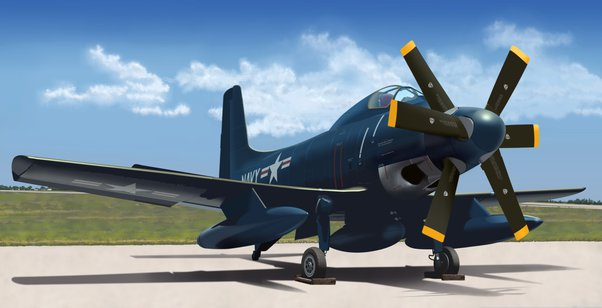

In [1]:
# @title #####__Imports__

locals().clear()
globals().clear()

import numpy as np
import matplotlib.pyplot as plt
from   scipy.optimize    import minimize
from   scipy.interpolate import RegularGridInterpolator


# 1) _DATA LOADING & PROCESSING_


In this section, the data obtained experimentally in [1] for the NACA 0012 airfoil profile at various angles of attack and h/c ratios are loaded. The presented data corresponds to U_inf = 30 m/s. Subsequently, they are interpolated using Monotone Cubic Hermite Interpolation (PCHIP) to preserve the monotonicity of the data and obtain a function of at least class C1.

It should be noted that additional data have been added to the data presented in [1] in order to model the curve even at high angles of attack (AoA).

[1] CFD analysis of the performance of different airfoils in ground effect Zubin Zaheer et al 2019 J. Phys.: Conf. Ser. 1355 012006

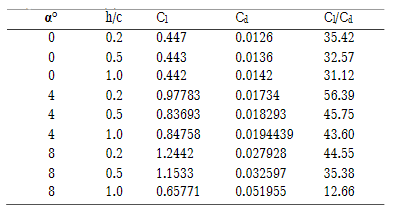

In [2]:
# @title #####__Airfoil & Problem Data Loading__

#from [1] + added stall
alpha_int = np.array([0.0, 4.0, 8.0, 13.0])
h_c_int   = np.array([0.2, 0.5, 1.0,  1.5])

Cl_int    = np.array([[-0.271240,-0.062150,-0.0047938,-0.0017938],
                      [ 0.454710, 0.428170, 0.3902000, 0.2902000],
                      [ 1.075700, 0.857320, 0.7918000, 0.6918000],
                      [ 0.454710, 0.428170, 0.3902000, 0.2902000]])

Cd_int    = np.array([[ 0.014698, 0.012230, 0.0117810, 0.012230],
                      [ 0.021619, 0.021712, 0.0214930, 0.021712],
                      [ 0.031047, 0.030974, 0.0334400, 0.030974],
                      [ 0.835781, 0.861610, 0.6710400, 0.7810470]])

RHO =  1.225  # Air density in kg/m^3
U_inf = 30.0  # m/s [1]
CHORD =  1.0  # Reference length

# [1] https://www.researchgate.net/publication/337645675_CFD_analysis_of_the_performance_of_different_airfoils_in_ground_effect


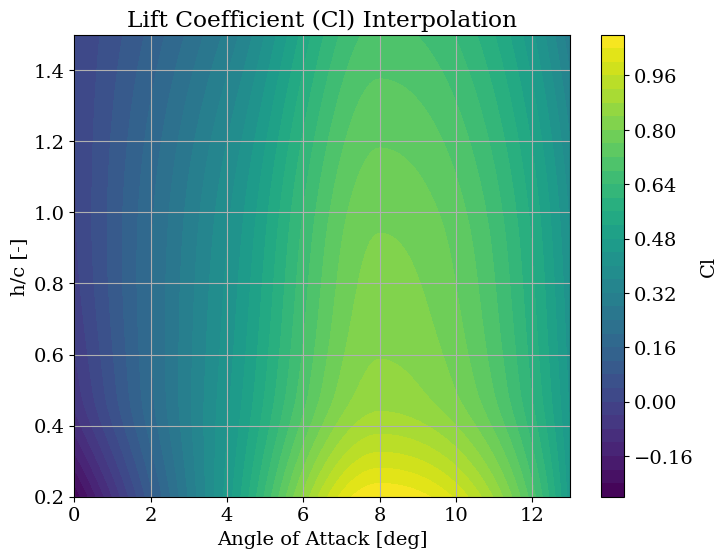

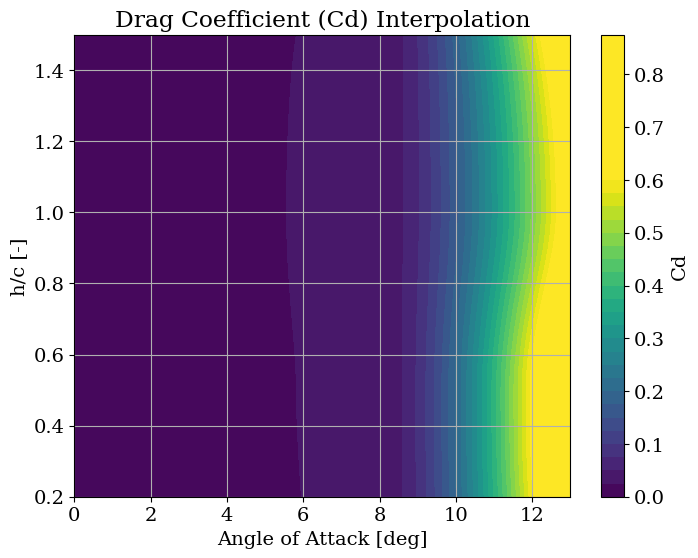

In [3]:
# @title #####__Data Processing__

#_______________________________________________________________________________
# DATA PRE-PROCESSING

num_points = 100

# Define the grid for alpha and h_c
alpha_grid = np.linspace(min(alpha_int), max(alpha_int), num_points)
h_c_grid = np.linspace(min(h_c_int), max(h_c_int), num_points)

# Create meshgrid for alpha and h_c
alpha_mesh, h_c_mesh = np.meshgrid(alpha_grid, h_c_grid, indexing='ij')

# Evaluate Cl and Cd on the grid points using RegularGridInterpolator
interp_Cl = RegularGridInterpolator((alpha_int, h_c_int), Cl_int, method='pchip')
interp_Cd = RegularGridInterpolator((alpha_int, h_c_int), Cd_int, method='pchip')

Cl_grid = interp_Cl((alpha_mesh, h_c_mesh))
Cd_grid = interp_Cd((alpha_mesh, h_c_mesh))

# Plot Cl
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False

plt.figure(figsize=(8, 6))
plt.contourf(alpha_mesh, h_c_mesh, Cl_grid, levels=40, cmap='viridis')
plt.colorbar(label='Cl')
plt.title('Lift Coefficient (Cl) Interpolation')
plt.xlabel('Angle of Attack [deg]')
plt.ylabel('h/c [-]')
plt.grid(True)
plt.show()

# Plot Cd
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False

plt.figure(figsize=(8, 6))
plt.contourf(alpha_mesh, h_c_mesh, Cd_grid, levels=40, cmap='viridis',  vmin=0.0, vmax=0.6)
plt.colorbar(label='Cd')
plt.title('Drag Coefficient (Cd) Interpolation')
plt.xlabel('Angle of Attack [deg]')
plt.ylabel('h/c [-]')
plt.grid(True)
plt.show()

# 2) _OPTIMIZATION PROBLEM_

In this section, the optimization problem is defined. Specifically, the aim is to minimize -Cl/Cd, and inequality constraints are imposed to ensure obtaining the desired solution. Cl and Cd are obtained by querying the interpolated curves based on the data.

In [4]:
# @title #####__Optimization Problem Definition__

#_______________________________________________________________________________
# PROBLEM DEFINITION: OBJECTIVE & CONSTRAINS

def lift_coefficient(alpha, h_c):
    eval_point = np.array([alpha[0], h_c])
    Cl = interp_Cl(eval_point)
    return Cl

# Function for drag coefficient calculation
def drag_coefficient(alpha, h_c):
    eval_point = np.array([alpha[0], h_c])
    Cd = interp_Cd(eval_point)
    return Cd

# Define function to calculate downforce and drag
def compute_forces(alpha, h_c):
    rho = RHO
    L_r = CHORD
    speed = U_inf

    lift_coeff = lift_coefficient(alpha, h_c)
    drag_coeff = drag_coefficient(alpha, h_c)
    return 0.5 * rho * L_r * speed**2 * lift_coeff, 0.5 * rho * L_r * speed**2 * drag_coeff

# Objective function to maximize downforce
def objective(alpha, h_c):
    lift_val, drag_val = compute_forces(alpha, h_c)
    return - (lift_val / (drag_val))

# Constraints to avoid zero
def lift_constraint(alpha, h_c):
    lift_val, _ = compute_forces(alpha, h_c)
    return lift_val - 100.0 # >= 0

def drag_constraint(alpha, h_c):
    _, drag_val = compute_forces(alpha, h_c)
    return drag_val + 10.0 # >= 0



h/c : 0.25

Optimization Variables: [10.81494355]
Objective Function Value: [-2.52125392]
Constraint Values:
Constraint 1: [376.78632391]
Constraint 2: [199.1068251]

Optimization Variables: [9.81549071]
Objective Function Value: [-5.57827065]
Constraint Values:
Constraint 1: [431.42682229]
Constraint 2: [105.26730703]

Optimization Variables: [7.16367495]
Objective Function Value: [-35.26539899]
Constraint Values:
Constraint 1: [442.65777446]
Constraint 2: [25.38782461]

Optimization Variables: [7.10212889]
Objective Function Value: [-35.27447427]
Constraint Values:
Constraint 1: [439.20955958]
Constraint 2: [25.28611186]

Optimization Variables: [7.10423757]
Objective Function Value: [-35.2744858]
Constraint Values:
Constraint 1: [439.33098585]
Constraint 2: [25.28954919]

Optimization Variables: [7.10423757]
Objective Function Value: [-35.2744858]
Constraint Values:
Constraint 1: [439.33098585]
Constraint 2: [25.28954919]

Optimization Status: True
Number of Iterations: 14
Final Opt

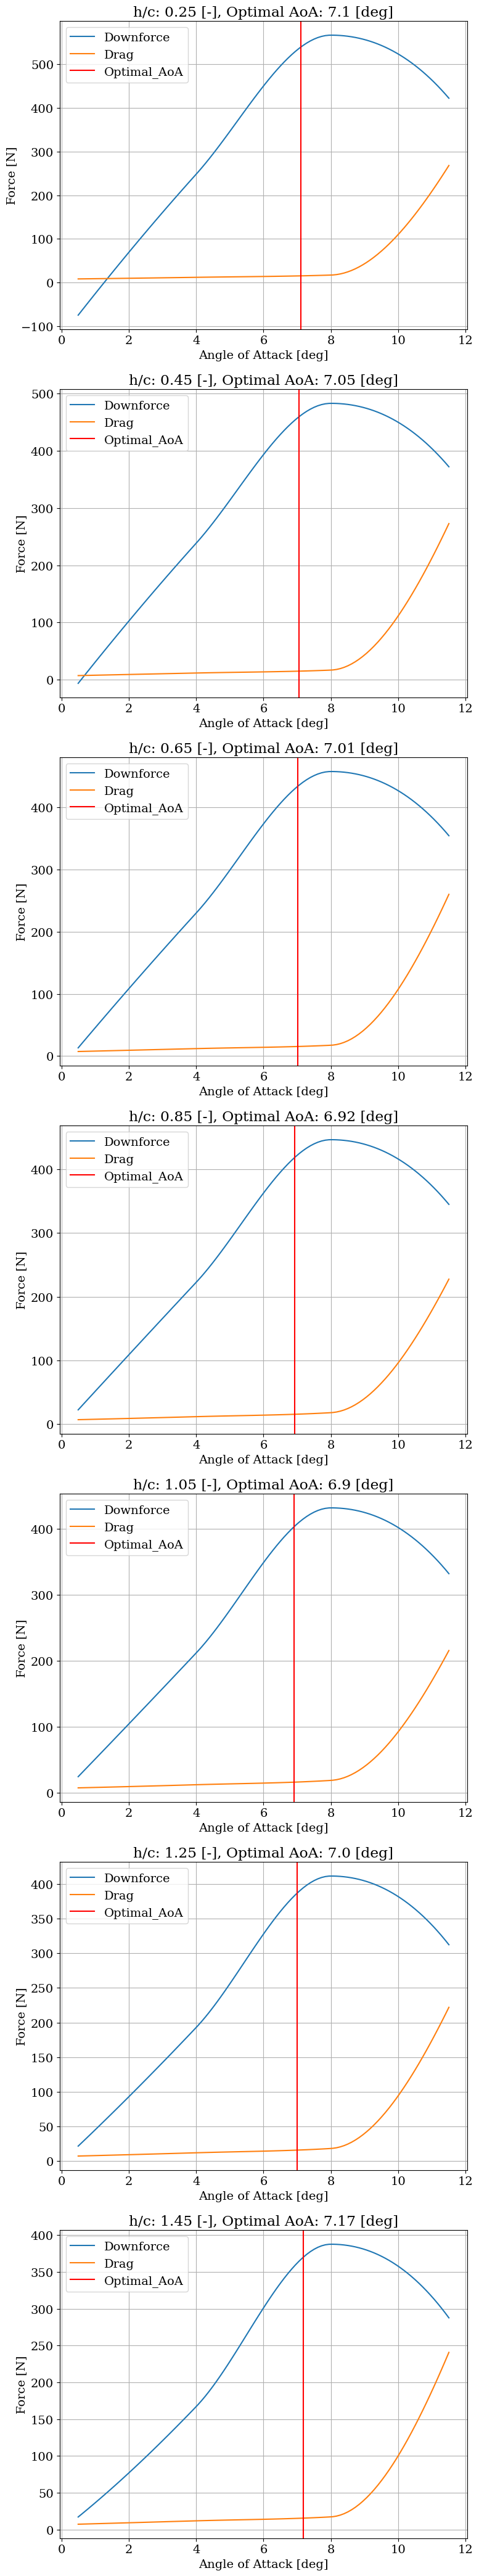

In [5]:
# @title #####__Optimization Loop__

#_______________________________________________________________________________
# OPTIMIZATION LOOP

# Loop over speeds
h_c_list = [0.25, 0.45, 0.65, 0.85, 1.05, 1.25, 1.45]  # [-]
max_AoA = 11.5
min_AoA = 0.5

# Initial guess for angle of attack
initial_guess = 2.0 # [deg]



initial_guess = np.clip(initial_guess, a_min=min_AoA, a_max=max_AoA)
optimal_angles = []
optimal_Cl = []
optimal_Cd = []

def print_iteration_info(x, objective_val, constraint_vals):
    print(f"Optimization Variables: {x}")
    print(f"Objective Function Value: {objective_val}")
    print("Constraint Values:")
    for i, val in enumerate(constraint_vals):
        print(f"Constraint {i + 1}: {val}")
    print()

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False
fig, axs = plt.subplots(len(h_c_list), figsize=(8, 6*len(h_c_list)))

for i, h_c in enumerate(h_c_list):

    # Optimization
    print('h/c :', h_c, end='\n')
    print()
    result = minimize(objective, initial_guess, args=(h_c,),
                      bounds=[(min_AoA, max_AoA)],
                      constraints=[{'type': 'ineq', 'fun': lift_constraint, 'args': (h_c,)},
                                   {'type': 'ineq', 'fun': drag_constraint, 'args': (h_c,)}],
                                    method='SLSQP',
                                    callback=lambda x: print_iteration_info(x, objective(x, h_c),
                                                      [lift_constraint(x, h_c), drag_constraint(x, h_c)]))

    print("Optimization Status:", result.success)
    print("Number of Iterations:", result.nfev)
    print("Final Optimization Message:", result.message)

    print('--------------------------------------------------------------------', end='\n')

    optimal_angles.append(result.x)
    optimal_Cd.append(lift_coefficient(result.x, h_c))
    optimal_Cl.append(drag_coefficient(result.x, h_c))

    alpha_values = np.linspace(min_AoA, max_AoA, 100)
    lift_values = np.array([compute_forces([alpha], h_c)[0] for alpha in alpha_values])
    drag_values = np.array([compute_forces([alpha], h_c)[1] for alpha in alpha_values])

    axs[i].plot(alpha_values, lift_values, label='Downforce')
    axs[i].plot(alpha_values, drag_values, label='Drag')
    axs[i].axvline(result.x,  color='red', label='Optimal_AoA')
    axs[i].set_title(f"h/c: {h_c} [-], Optimal AoA: {round(result.x[0], 2)} [deg]")
    axs[i].set_xlabel('Angle of Attack [deg]')
    axs[i].set_ylabel('Force [N]')
    axs[i].grid()
    axs[i].legend()

plt.tight_layout()
plt.show()


# 3) _OPTIMIZATION RESULTS_

Below are the results of the optimization process depicted in two graphs: one showing the height from the ground (h/c *c) against AoA with the Cl/Cd result overlaid, and the second graph showing the same plot but with the gradient of Cl/Cd. These graphs demonstrate how the process has reached the optimum and illustrate that the problem is convex in nature.

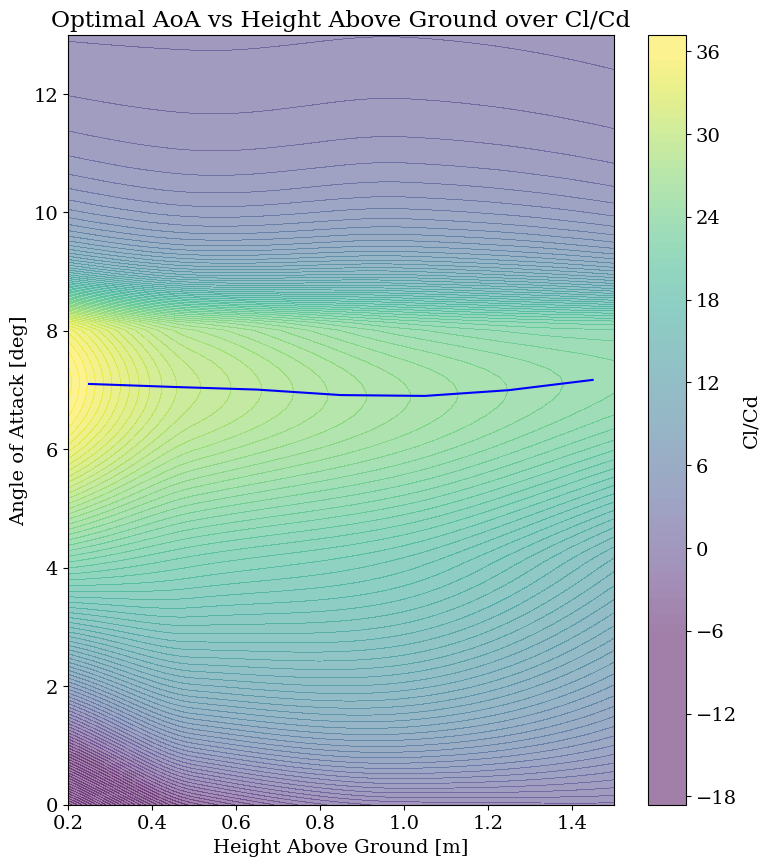

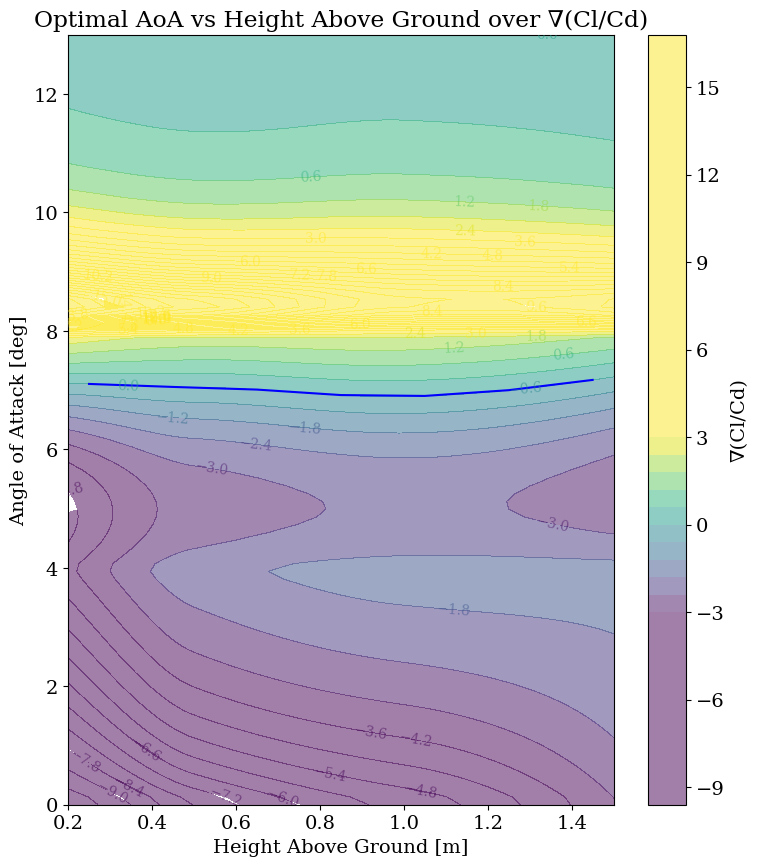

In [6]:
# @title #####__Optimization Results__

#_______________________________________________________________________________
# FINAL PLOT

h_c_list_mod = np.concatenate(([0], h_c_list))
h_c_diff = np.mean(np.array([h_c_list_mod[i] - h_c_list_mod[i - 1] for i in range(1, len(h_c_list_mod))]))

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False

fig, ax1 = plt.subplots(figsize=(8.8, 10))

# Plot optimal angle of attack
ax1.plot(np.array(h_c_list) * CHORD, optimal_angles, color='blue', label='Optimal AoA')
ax1.set_xlabel('Height Above Ground [m]')
ax1.set_ylabel('Angle of Attack [deg]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

#Limit y-axis visualization
#y_min = min(optimal_angles) - 0.3
#y_max = max(optimal_angles) + 0.3
#ax1.set_ylim(y_min, y_max)

contour = plt.contourf(h_c_grid * CHORD, alpha_grid, Cl_grid/Cd_grid, levels=100, cmap='viridis', alpha=0.5, vmin=-6, vmax=+36)
cbar = plt.colorbar(label='Cl/Cd')


plt.title('Optimal AoA vs Height Above Ground over Cl/Cd')
plt.grid(which='both', axis='both')

plt.show()


#-------------------------------------------------------------------------------

plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['text.usetex'] = False

fig, ax1 = plt.subplots(figsize=(8.8, 10))

# Plot optimal angle of attack
ax1.plot(np.array(h_c_list) * CHORD, optimal_angles, color='blue', label='Optimal AoA')
ax1.set_xlabel('Height Above Ground [m]')
ax1.set_ylabel('Angle of Attack [deg]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

#Limit y-axis visualization
#y_min = min(optimal_angles) - 1
#y_max = max(optimal_angles) + 1
#ax1.set_ylim(y_min, y_max)

grad_ClCd = - np.gradient(np.array(Cl_grid/Cd_grid), h_c_diff, 1)[0]

contour = plt.contourf(h_c_grid * CHORD, alpha_grid, grad_ClCd, levels=50, cmap='viridis', alpha=0.5, vmin=-3, vmax=+3)
cbar = plt.colorbar(label='∇(Cl/Cd)')

plt.title('Optimal AoA vs Height Above Ground over ∇(Cl/Cd)')
plt.clabel(contour, inline=True, fontsize=10)
plt.grid(which='both', axis='both')

plt.show()